In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy.stats import t
import scipy.stats as st
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

from mapie.metrics import regression_coverage_score

In [3]:
Bedrooms = [1,1,1,2,2,2,2,3,3,3,3,3,3,3,4,4,4,5,5,6]
Prices = [120,133,139,185,148,160,192,205,244,213,236,280,275,273,312,311,304,415,396,488]

In [4]:
sample = np.array(random.choices(Bedrooms, k = 10))

m = sample.mean()
s = sample.std()
print(m)
print(s)

confidence = 0.95
dof = len(sample)-1 
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
print(t_crit)
left_bound = m-s*t_crit/np.sqrt(len(sample))
right_bound = m+s*t_crit/np.sqrt(len(sample))
confidence_interval = [left_bound, right_bound]
print(confidence_interval)

mean_population = np.array(Bedrooms).mean()
mean_population

2.7
1.1874342087037917
2.2621571627409915
[1.8505607384394147, 3.5494392615605856]


3.0

In [10]:
# Confidence Intervals Using the t Distribution
st.t.interval(confidence=0.95, df=len(sample)-1, loc=np.mean(sample), scale=st.sem(sample)) 

(1.8046123998323456, 3.595387600167655)

In [9]:
# Confidence Intervals Using the Normal Distribution
st.norm.interval(confidence=0.95, loc=np.mean(sample), scale=st.sem(sample))

(1.9242239056432502, 3.47577609435675)

In [57]:
data = pd.DataFrame({"Bedrooms":np.array(Bedrooms), "Prices":np.array(Prices)})
print(data.cov())

            Bedrooms        Prices
Bedrooms    1.894737    133.894737
Prices    133.894737  10016.155263


Text(0.5, 1.0, 'Correlation Heatmap')

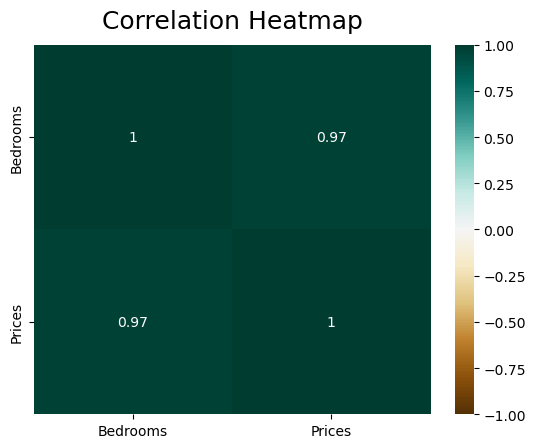

In [34]:
heatmap = sns.heatmap(data.corr(), vmin = -1, vmax = 1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=12)

In [16]:
x = np.array(Bedrooms).reshape((-1,1))
y = np.array(Prices)

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(f"coefficient of determination. {round(r_sq, 4)}")

print(f"intercept: {round(model.intercept_, 4)}")
print(f"slop: {model.coef_}")

y_hat = model.predict(x).round(4)
print(f"y_hat: {y_hat}")

RSS = np.sum(np.square(y - y_hat))
rse = math.sqrt(RSS / (len(Bedrooms) - 2))
print(f"Residual Error: {rse}")

coefficient of determination. 0.9447
intercept: 39.45
slop: [70.66666667]
y_hat: [110.1167 110.1167 110.1167 180.7833 180.7833 180.7833 180.7833 251.45
 251.45   251.45   251.45   251.45   251.45   251.45   322.1167 322.1167
 322.1167 392.7833 392.7833 463.45  ]
Residual Error: 24.18786158693837


Mean absolute error with 95% CI: 23.938 ± 3.232
MAE: 16.122
Width of 95% prediction interval: 103.691864
Coverage: 1.000


C:\Users\darvi\AppData\Local\Temp\ipykernel_30324\936186221.py:6: DeprecationWarning: Please use `sem` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  sem = st.stats.sem(scores)


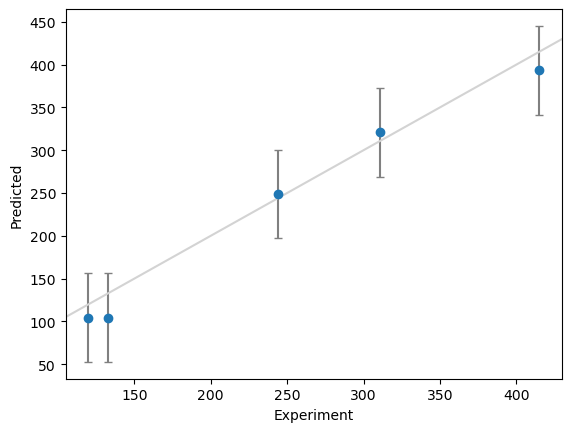

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

est = LinearRegression()
scores = cross_val_score(est, x, y, cv=10, scoring=make_scorer(mean_absolute_error))
sem = st.stats.sem(scores)
print(f"Mean absolute error with 95% CI: {np.mean(scores):.3f} ± {sem * 1.96:.3f}")

# Fit the scikit-learn model
est = LinearRegression()
est.fit(X_train, y_train)
y_train_pred = est.predict(X_train)
y_test_pred = est.predict(X_test)

# Compute prediction intervals
sum_of_squares = np.sum((y_train - y_train_pred) ** 2)
std = np.sqrt(1 / (len(y_train) - 2) * sum_of_squares)

# Plot the prediction intervals
y_err = np.vstack([std, std]) * 1.96
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

# Print out statistics
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(
    y_test, y_test_pred - std * 1.96, y_test_pred + std * 1.96
)
print(f"Coverage: {coverage:.3f}")

In [59]:
def prediction_interval(new_value, x, y, y_hat, alpha = 0.1, df = 2):
    n = len(x)
    re = np.sqrt(np.square(y-y_hat).sum()/(n-2))
    se = re * np.sqrt((1+(1/n)+((np.square(new_value-x.mean()))/(np.square(x-x.mean()).sum()))))

    t_value = t.ppf(1-alpha/2, df = df)
    interval = t_value * se
    print(t_value)
    
    y_pred = model.predict(np.array([[new_value]]))
    LCL = y_pred -  interval
    UCL = y_pred +  interval
    
    return y_pred, LCL, UCL

y_pred, LCL, UCL = prediction_interval(7, x, y, y_hat, alpha = 0.1, df = 2)
print(f"LCL: {LCL}")
print(f"UCL: {UCL}")

print("The prediction %f with 99 confidence lies between [%f, %f]"%(y_pred, LCL, UCL))

2.919985580355516
LCL: [447.77546893]
UCL: [620.45786441]
The prediction 534.116667 with 99 confidence lies between [447.775469, 620.457864]


In [56]:
residuals = y - y_pred
n = len(x)
p = 2
MSE = np.sum(residuals**2) / (n-p)
SE = np.sqrt(MSE)
SE

315.19974609487184